In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt
#from corner import corner

starry.config.quiet = True

In [2]:
# True values
truth = dict(contrast=0.25, radius=20, lat=30, lon=30)

In [3]:
# Things we'll assume are known
inc = 60.0
P = 1.0

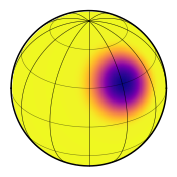

In [4]:
map = starry.Map(15)
map.inc = inc
map.spot(
    contrast=truth["contrast"],
    radius=truth["radius"],
    lat=truth["lat"],
    lon=truth["lon"],
)
map.show()

In [5]:
t = np.linspace(0, 3.0, 500)
flux0 = map.flux(theta=360.0 / P * t).eval()
np.random.seed(0)
flux_err = 2e-4
flux = flux0 + flux_err * np.random.randn(len(t))
flux = flux/np.mean(flux)

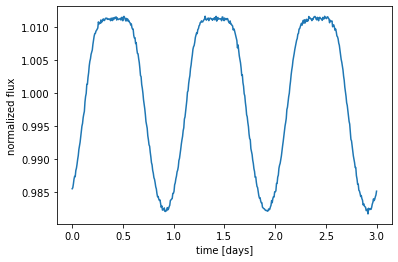

In [6]:
plt.plot(t, flux)
plt.xlabel("time [days]")
plt.ylabel("normalized flux");

In [16]:
help(Elemwise{mul,no_inplace}.0)

SyntaxError: invalid syntax (<ipython-input-16-56b2cc5e04b6>, line 1)

In [7]:
with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = pm.Uniform("radius", lower=10.0, upper=60.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)

    # Instantiate the map and add the spot
    map = starry.Map(ydeg=15)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=360.0 / P * t)
    flux_model = flux_model/tt.mean(flux_model) # error here

    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, lat, radius, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -257846.10288209148 -> 3540.4031577845194


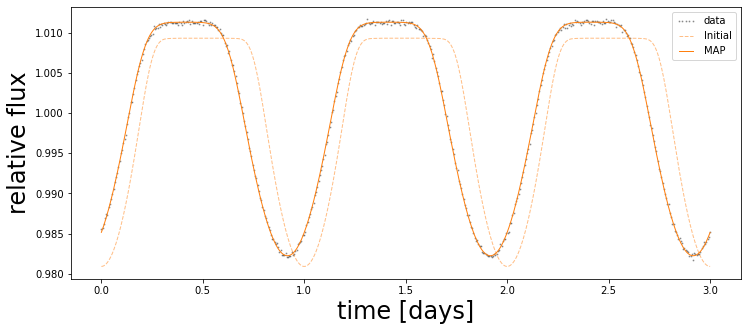

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [10]:
print("{0:12s} {1:10s} {2:10s}".format("", "truth", "map_soln"))
for key in truth.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth[key], map_soln[key]))

             truth      map_soln  
contrast      0.25000    0.25081
radius       20.00000   19.95735
lat          30.00000   29.78165
lon          30.00000   29.94851


In [11]:
print("{0:12s} {1:10s} ".format("", "truth"))
for key in truth.keys():
    print("{0:10s} {1:10.5f}".format(key, truth[key]))

             truth      
contrast      0.25000
radius       20.00000
lat          30.00000
lon          30.00000


In [12]:
print("{0:12s} {1:10s} {2:10s}".format("", "truth", "map_soln"))
for key in map_soln.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth[key], map_soln[key]))

             truth      map_soln  


KeyError: 'contrast_interval__'

In [15]:
map_soln.keys()

dict_keys(['contrast_interval__', 'radius_interval__', 'lat_interval__', 'lon_interval__', 'contrast', 'radius', 'lat', 'lon', 'flux_model'])

In [16]:
map_soln.keys()

TypeError: 'dict_keys' object is not subscriptable

In [21]:
map.flux(theta=360.0 / P * t).median

AttributeError: 'TensorVariable' object has no attribute 'median'

In [22]:
map.flux(theta=360.0 / P * t)

Elemwise{mul,no_inplace}.0